# Comparison of two antibody panels with different order. <a name="contents"></a>

**Question:** How does the stain sensitivity and specificity change when you apply the same antibodies in a different order? 

**Samples:** 
- A TMA containing HER2+ breast cancer tissue, purchased from Biomax. https://www.biomax.us/tissue-arrays/Breast/Her2B
- Sections:
    - K154 is the original order
    - K175 is the optimized order.

**Method**: Cells were classified as tumor, endothelial, immune (T cell or macrophage) and stormal. For each stain, single cell pixel intensity in cells that should be positive was compared to cells that should be negative. For example, CD45 in T cells (i.e. specicifc signal) was compared to CD45 in tumor cells (i.e. non-specific background). The original antibody order was compared to the optimized order.

**[Napari Analysis](#napari)**

In order to compare background in specific areas of the tissue, e.g. nuclear non specific staining in tumor cells, we manually defined faorground and background regions using the napari image viewer. Foreground and background masks were saved for repoducing this analysis.


In [ ]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
import seaborn as sns
from sklearn import preprocessing
matplotlib.rcParams.update({'font.size': 12})


round changes, old (K154) to new (K175)

same- CK19, ER, HER2


| Marker | Original | Optimized |
|--------|----------|-----------|
| CD4    | 3        | 7         |
| CD8    | 1        | 7         |
| CD20   | 6        | 8         |
| CD31   | 4        | 10        |
| CD44   | 4        | 3         |
| CD45   | 2        | 6         |
| CD68   | 2        | 6         |
| CK14   | 5        | 1         |
| CK5    | 2        | 4         |
| CK7    | 5        | 6         |
| CK8    | 9        | 8         |
| CK17   | 7        | 9         |
| ColI   | 8        | 9         |
| ColIV  | 10       | 8         |
| Ecad   | 3        | 2         |
| EGFR   | 7        | 4         |
| FoxP3  | 10       | 5         |
| GRNZB  | 7        | 10        |
| H3K4   | 10       | 9         |
| H3K27  | 8        | 10        |
|Ki67|      5    |   1        |
|LamAC|     11     |    4       |
|LamB1|     11     |    10       |
|Lam B2|    11      |     12      |
|PCNA|    1      |     2      |
|PD1|    1      |    6       |
|PDPN|    8      |    5       |
|PgR|    5      |      7     |
|pAKT|    7      |     3      |
|pERK|    6      |     5     |
|pHH3|    6      |     5     |
|pRB|     9     |     4     |
|  pS6    |    6      |     10      |
|Vim|     4     |     7      |

In [ ]:
#set location of files
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()

In [ ]:
#load positive (thresholded using AF subtracted for K154/ non AF sub for K175)
df_pos = pd.read_csv(f'{codedir}/Data/Her2B-K154-6S_DAPI11_Nuclei1000_ManualPositive.txt',index_col=0,sep='\t')
df_pos['scene'] = ['scene'+ item.split('_')[1].split('scene0')[1] for item in df_pos.index]

df_pos_new = pd.read_csv(f'{codedir}/Data/Her2B-K175_DAPI12_Nuclei1000_ManualPositive.csv',index_col=0)


#read in full features (all locations, cells) ***data too big***
#df_mi = pd.read_csv(f'{codedir}/BigData/features_Her2B-K154-6S_MeanIntensity.tsv',index_col=0,sep='\t')
#df_mi['scene'] = ['scene'+ item.split('_')[0].split('scene0')[1] for item in df_mi.index]

#df_mi_new = pd.read_csv(f'{codedir}/BigData/features_HER2B-K175_MeanIntensity.tsv',index_col=0,sep='\t')
#df_mi_new['scene'] = [item.split('_')[0] for item in df_mi_new.index]
#save smaller dataframes
#for s_slide in sorted(set(df_mi.scene)):
#    df_mi[df_mi.scene==s_slide].to_csv(f'{codedir}/Data/features_Her2B-K154-6S-{s_slide}_MeanIntensity.csv')
#save smaller dataframes
#for s_slide in sorted(set(df_mi_new.scene)):
#    df_mi_new[df_mi_new.scene==s_slide].to_csv(f'{codedir}/Data/features_HER2B-K175-{s_slide}_MeanIntensity.csv')
#df_mi_new = df_mi_new[df_mi_new.scene.isin(['scene02', 'scene04', 'scene05', 'scene06', 'scene08', 'scene09'])]
#df_pos_new = df_pos_new[df_pos_new.scene.isin(['scene02', 'scene04', 'scene05', 'scene06', 'scene08', 'scene09'])]

In [ ]:
df_mi = pd.DataFrame()
df_mi_new = pd.DataFrame()
for s_scene in ['scene02', 'scene04', 'scene05', 'scene06', 'scene08', 'scene09']:
    df_mi = df_mi.append(pd.read_csv(f'{codedir}/Data/features_Her2B-K154-6S-{s_scene}_MeanIntensity.csv',index_col=0))
    df_mi_new = df_mi_new.append(pd.read_csv(f'{codedir}/Data/features_HER2B-K175-{s_scene}_MeanIntensity.csv',index_col=0))


In [ ]:
set(df_mi.scene)

In [ ]:
print(len(df_mi))
print(len(df_pos))
print(len(df_mi_new))
print(len(df_pos_new))

# K154 and K175 analysis plan

1 - use "good" markers (based on visual estimation of staining; low background markers) to define 5 tissue compartments.

2 - calculate the signal for each marker (expression in correct compartment) e.g. for CD45, T-cell cytoplasm

3 - calculate the background for each marker (expression in incorrect compartment) - e.g. for CD45, tumor nuclei

4 - Visualize intensity distribution of early and late signal and background

5 - Also estimate dynamic range and early/late correlation in ROIs using percentile (4th and 99th) 


In [ ]:
d_scene = {'AR_Nuclei':['scene008'],
           'aSMA_Ring':['scene002','scene006'],
           'CD4_Ring':['scene002','scene008'],
           'CD8_Ring':['scene002','scene008'],
           'CD20_Ring':['scene008'], #'scene002',
           'CD31_Ring':['scene002','scene006','scene008'],
           'CD44_Ring':['scene002','scene006','scene008'],
           'CD45_Ring':['scene002','scene008','scene006'],
           'CD68_Ring':['scene002','scene006','scene008'],
           'CK5_Ring':['scene006'],
           'CK7_Ring':['scene002','scene006'],
           'CK8_Ring':['scene002','scene006','scene008'],
           'CK14_Ring':['scene006'],
           'CK17_Ring':['scene006'],
           'CK19_Ring':['scene002','scene006','scene008'],
           'ColI_Ring':['scene006'],
           'ColIV_Ring':['scene006'],
           'cPARP_Nuclei':['scene002'],
           'Ecad_Ring':['scene002','scene008'],
           'ER_Nuclei':['scene008'],
           'FoxP3_Nuclei':['scene002','scene008'],
           'GRNZB_Nuclei':['scene002','scene006'],
           'H3K4_Nuclei':['scene002','scene008'],
           'H3K27_Nuclei':['scene002','scene008'],
           'HER2_Ring':['scene002','scene006'],
           'Ki67_Nuclei':['scene002','scene006','scene008'],
           'LamAC_Nuclei':['scene002','scene006','scene008'],
           'LamB1_Nuclei':['scene002','scene008'],
           'LamB2_Nuclei':['scene002','scene006','scene008'],
           'PCNA_Nuclei':['scene002','scene008'],
           'PD1_Ring':['scene008'],
           'PDPN_Ring':['scene002','scene008'],
           'PgR_Nuclei':['scene008'],
           'pRB_Nuclei':['scene008'],
           'pS6RP_Ring':['scene008'],
           'S100_Nuclei':['scene006'],
           'Vim_Ring':['scene002','scene006','scene008'],
          }

# dynamic range and SBR

In [ ]:
# ROIs that have known positive cells
#crop
d_crop = {
    'Her2B-K154-Scene-002':(3014,3437),
    'Her2B-K154-Scene-006':(4154,4909),
    'Her2B-K154-Scene-008':(3101,1923),
    'HER2B-K175-Scene-02':(3443,3970),
    'HER2B-K175-Scene-06':(2925,4671),
    'HER2B-K175-Scene-08':(4593,4000),
  }


df_xy = df_pos.loc[:,['DAPI_X','DAPI_Y','scene']]
df_xy['slide'] = [item.split("-6S")[0] for item in df_xy.index] 
df_xy['slide_scene'] = df_xy.slide + '_' + df_xy.scene

df_rois = pd.DataFrame()
for s_scene, t_coord in d_crop.items():
        x_min = t_coord[0]
        x_max = t_coord[0] + 800
        y_min = t_coord[1]
        y_max = t_coord[1] + 800
        df_scene = df_xy[df_xy.slide_scene==s_scene]
        df_scene = df_scene.loc[(x_max > df_scene.DAPI_X) & (df_scene.DAPI_X > x_min)]
        df_scene = df_scene.loc[(y_max > df_scene.DAPI_Y) & (df_scene.DAPI_Y > y_min)]
        df_rois = df_rois.append(df_mi.loc[[item.split("6S_")[1] for item in df_scene.index],:])

In [ ]:
#compartments

#define tumor and immune cell types
ls_tumor = ['CK19_Ring','CK5_Ring','Ecad_Ring','CK14_Ring'] # #'CK7_Ring'= poor quench, CK17_Ring = too many pos comapred to CK5 and CK14
ls_exclude = ['CD31_Ring','CD68_Ring','CD4_Ring'] # cd45 not good?
df_pos['all-tumor'] = df_pos.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos['not-tumor'] = df_pos.loc[:,ls_exclude].sum(axis=1)>=1
df_pos['not-tumor-not-Tcell'] = df_pos.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos['tumor'] = (df_pos.loc[:,'all-tumor'].astype(int) -  df_pos.loc[:,'not-tumor'].astype(int))==1
df_pos['Endothelial'] = df_pos.loc[:,'CD31_Ring']
df_pos['Macrophage'] = (df_pos.loc[:,'CD68_Ring'].astype(int) - df_pos.loc[:,'CD31_Ring'].astype(int)) == 1
#df_pos['Tcell'] = (df_pos.loc[:,'CD4_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos['CD4Tcell'] = (df_pos.loc[:,'CD4_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos['CD8Tcell'] = (df_pos.loc[:,'CD8_Ring'].astype(int) + df_pos.loc[:,'CD45_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==2
df_pos['T-cell'] = (df_pos.loc[:,'CD8Tcell'].astype(int) + df_pos.loc[:,'CD4Tcell'].astype(int)) >= 1
df_pos['Basal'] = (df_pos.loc[:,'tumor'].astype(int) - df_pos.loc[:,'CK19_Ring'].astype(int)) == 1

df_pos['Stromal'] = (df_pos.loc[:,['tumor']].sum(axis=1) ==0)#,'Tcell','Mac','Endothelial'
df_pos = df_pos.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)

#new order
df_pos_new['all-tumor'] = df_pos_new.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos_new['not-tumor'] = df_pos_new.loc[:,ls_exclude].sum(axis=1)>=1
df_pos_new['not-tumor-not-Tcell'] = df_pos_new.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos_new['tumor'] = (df_pos_new.loc[:,'all-tumor'].astype(int) -  df_pos_new.loc[:,'not-tumor'].astype(int))==1
df_pos_new['Endothelial'] = df_pos_new.loc[:,'CD31_Ring']
df_pos_new['Macrophage'] = (df_pos_new.loc[:,'CD68_Ring'].astype(int) - df_pos_new.loc[:,'CD31_Ring'].astype(int)) == 1
df_pos_new['CD4Tcell'] = (df_pos_new.loc[:,'CD4_Ring'].astype(int) -  df_pos_new.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos_new['CD8Tcell'] = (df_pos_new.loc[:,'CD8_Ring'].astype(int) + df_pos_new.loc[:,'CD45_Ring'].astype(int) -  df_pos_new.loc[:,'not-tumor-not-Tcell'].astype(int))==2
df_pos_new['T-cell'] = (df_pos_new.loc[:,'CD8Tcell'].astype(int) + df_pos_new.loc[:,'CD4Tcell'].astype(int)) >= 1
df_pos_new['Basal'] = (df_pos_new.loc[:,'tumor'].astype(int) - df_pos_new.loc[:,'CK19_Ring'].astype(int)) == 1

df_pos_new['Stromal'] = (df_pos_new.loc[:,['tumor']].sum(axis=1) ==0)
df_pos_new = df_pos_new.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)


In [ ]:
#five compartments
df_pos.loc[:,['tumor','CD4Tcell','CD8Tcell','Macrophage','Endothelial','Stromal','Basal']].sum()

In [ ]:
#five compartments
df_pos_new.loc[:,['tumor','T-cell','Macrophage','Endothelial','Stromal','Basal']].sum()

In [ ]:
#Annotate the compartment of signal and background for each marker
#dd key is forground, d key is cell type, d item is bg
dd_exclusive = {'CD4Tcell':{ 'FoxP3_Nuclei':'tumor',
    'GRNZB_Nuclei':'tumor',
    'PD1_Ring':'tumor',
    'CD20_Ring':'tumor',
    'CD45_Ring':'tumor',
    'CD4_Ring':'tumor'},
 'CD8Tcell': {'CD8_Ring':'tumor'},
'tumor':{'CK8_Ring':'Stromal',
    'Ecad_Ring':'Stromal',
    'PgR_Nuclei':'Stromal',
        'LamAC_Nuclei':'Stromal',
        'pRB_Nuclei':'Stromal',
        'Ki67_Nuclei':'Stromal'},
'Basal':{    'CK5_Ring':'Stromal',
    'CK17_Ring':'Stromal',
    'CK14_Ring':'Stromal',
    'aSMA_Ring':'T-cell',
    'ColIV_Ring':'tumor',},
'Endothelial': {'CD31_Ring':'tumor',},
'Mac':{'CD68_Ring':'tumor',},
'Stromal':{
        'PDPN_Ring':'tumor',
        'CD44_Ring':'Endothelial',
        'Vim_Ring':'tumor',}
               }

In [ ]:
#produce single cell histograms

for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items():  
        s_marker = 'CD45_Ring'
        boolx = True
        if s_marker=='CD45_Ring':
            boolx=False
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),sharex=boolx,sharey=boolx,dpi=200)
        ax=ax.ravel()
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        #old
        i_bins = 500
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[0],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[0],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Original')
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        if s_marker == 'CD45_Ring':
            i_bins=300
        se_fg = df_mi_new.loc[fg_index,f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[1],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[1],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[1].legend()
        ax[1].set_xlabel('Optimized')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_histogram_{s_marker.split("_")[0]}.png')
        if s_marker == 'CD45_Ring':
            ax[1].set_xlim(0,5000)
            ax[1].set_ylim(0,650)
            ax[0].set_xlim(0,15000)
            ax[0].set_ylim(0,500)
            fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_Zoomedhistogram_{s_marker.split("_")[0]}.png')
        else:
            plt.close(fig)
        break
    break
                    

    

In [ ]:
#plot
df_result = pd.DataFrame(index=sorted(d_scene.keys()))
#histogram intersection
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

bins=400
for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items(): 
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[df_mi.index.isin(fg_index),s_marker]
        se_bg = df_mi.loc[df_mi.index.isin(bg_index),f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        df_result.loc[s_marker,'Original_S'] = se_fg.mean()
        df_result.loc[s_marker,'Original_BG'] = se_bg.mean()   
        h1,edges = np.histogram(se_fg.values, bins, range=(se_fg.append(se_bg).min(),se_fg.append(se_bg).max()))
        h2,__ = np.histogram(se_bg.values, bins, range=(se_fg.append(se_bg).min(),se_fg.append(se_bg).max()))
        #edges = np.interp(edges, (edges.min(), edges.max()), (-1, 1))
        #min_max_scaler = preprocessing.MinMaxScaler()
        #X_train_minmax = min_max_scaler.fit_transform(edges.reshape(-1, 1))
        #edges = X_train_minmax.ravel()
        sm = histogram_intersection(h1, h2, edges)
        #print(edges.max()-edges.min())
        df_result.loc[s_marker,'Original_Intersection'] = sm
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        se_fg = df_mi_new.loc[df_mi_new.index.isin(fg_index),f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[df_mi_new.index.isin(bg_index),f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        df_result.loc[s_marker,'Optimized_S'] = se_fg.mean()
        df_result.loc[s_marker,'Optimized_BG'] = se_bg.mean()   
        h1,__ = np.histogram(se_fg.values, bins, range=(se_fg.append(se_bg).min(),se_fg.append(se_bg).max()))
        h2,edges = np.histogram(se_bg.values, bins, range=(se_fg.append(se_bg).min(),se_fg.append(se_bg).max()))
        sm = histogram_intersection(h1, h2, edges)
        df_result.loc[s_marker,'Optimized_Intersection'] = sm


In [ ]:
ls_marker = ['CD31_Ring', 'CD44_Ring', 'CD45_Ring', 'CD4_Ring',
       'Vim_Ring','PD1_Ring']
fig,ax=plt.subplots()
df_result.loc[ls_marker,['Original_Intersection','Optimized_Intersection']].dropna().plot(kind='bar',log=True,alpha=0.8,ax=ax)

In [ ]:
fig,ax=plt.subplots(figsize=(5,8))
df= df_result.loc[:,['Original_Intersection','Optimized_Intersection']].dropna().sort_values('Original_Intersection')
df.index = [item.split('_')[0] for item in df.index]
df.plot(kind='barh',log=True,alpha=0.8,ax=ax)
ax.set_title('Histogram Intersection',fontsize=20)
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K175/Original_Optimized_barplot.png')

In [ ]:
matplotlib.rcParams.update({'font.size': 18})
df_long = df.melt()
#plot false positives
fig, ax = plt.subplots(figsize=(3.5,4),dpi=200)
sns.boxplot(data=df_long,x='variable',y='value',showfliers=False, boxprops=dict(alpha=.7))
sns.stripplot(data=df_long,x='variable',y='value')
ax.set_xticklabels(['Orig.','Opt.'])
ax.set_title('Histogram\n Intersection',fontsize=22)
ax.set_ylabel('Pixel Overlap')
ax.set_xlabel('Order')
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K175/Original_Optimized_boxplot.png')

In [ ]:
#not significant in this tissue
stat, p = stats.mannwhitneyu(x=df.loc[:,'Original_Intersection'].values, y=df.loc[:,'Optimized_Intersection'].values)
p

In [ ]:
#the mean does not capture; use histogram intersection
df_result['Original_SBR']=df_result['Original_S']/df_result['Original_BG']
df_result['Optimized_SBR']=df_result['Optimized_S']/df_result['Optimized_BG']
df_result.loc[:,['Original_SBR','Optimized_SBR']].dropna().plot(rot=90,figsize=(12,3))
#plt.xticks(range(len(df_result.loc[:,['Original_SBR','Optimized_SBR']].dropna().index)), df_result.loc[:,['Original_SBR','Optimized_SBR']].dropna().index)

In [ ]:
# kde

for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items():  
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),dpi=200)
        ax=ax.ravel()
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        #old
        i_bins = 500
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        i_max = np.quantile(se_fg.append(se_bg),.998)
        sns.kdeplot(se_fg,ax=ax[0],shade=True,label='S',alpha=0.4)                       
        sns.kdeplot(se_bg,ax=ax[0],shade=True,label='BG',alpha=0.4)
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Original')
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        se_old = se_fg
        se_fg = df_mi_new.loc[fg_index,f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        se_new = se_fg
        i_max = np.quantile(se_old.append(se_new),.99)
        sns.kdeplot(se_fg,ax=ax[1],shade=True,label='S',alpha=0.4,clip=(0,i_max))                       
        sns.kdeplot(se_bg,ax=ax[1],shade=True,label='BG',alpha=0.4,clip=(0,i_max))
        ax[1].legend()
        ax[1].set_xlim(0,i_max)
        ax[0].set_xlim(0,i_max)
        ax[0].set_yticklabels('')
        ax[1].set_yticklabels('')
        ax[1].set_xlabel('Optimized')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_kde_{s_marker.split("_")[0]}.png')
        if s_marker == 'CD45_Ring':
            ax[1].set_xlim(0,5000)
            ax[0].set_xlim(0,16000)
            fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_Zoomedkde_{s_marker.split("_")[0]}.png')
        else:
            plt.close(fig)
        break
    break

                  

In [ ]:
#PD1
for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items():     
        s_marker='PD1_Ring'
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),sharex=True,sharey=True,dpi=200)
        ax=ax.ravel()
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        #old
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        i_bins = 500
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1]}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[0],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[0],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Original')
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        #fg_index = set(marker_index) - set(bg_index)
        se_fg = df_mi_new.loc[fg_index,f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1]}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[1],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[1],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[1].legend()
        ax[1].set_xlabel('Optimized')
        ax[1].set_xlim(0,10000)
        ax[1].set_ylim(0,500)
        ax[0].set_xlim(0,10000)
        ax[0].set_ylim(0,500)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_histogram_{s_marker.split("_")[0]}_Ring.png')
        break
    break

In [ ]:
#PD1
for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items():     
        s_marker='PD1_Ring'
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),dpi=200)
        ax=ax.ravel()
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        #old
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        i_bins = 500
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1]}"]
        sns.kdeplot(se_fg,ax=ax[0],shade=True,label='S',alpha=0.4)              
        sns.kdeplot(se_bg,ax=ax[0],shade=True,label='BG',alpha=0.4)
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Original')
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        #fg_index = set(marker_index) - set(bg_index)
        se_fg = df_mi_new.loc[fg_index,f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1]}"]
        sns.kdeplot(se_fg,ax=ax[1],shade=True,label='S',alpha=0.4)                   
        sns.kdeplot(se_bg,ax=ax[1],shade=True,label='BG',alpha=0.4)
        ax[1].legend()
        ax[1].set_xlabel('Optimized')
        ax[1].set_xlim(0,12000)
        ax[0].set_xlim(0,12000)
        ax[0].set_yticklabels('')
        ax[1].set_yticklabels('')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_kde_{s_marker.split("_")[0]}_Ring.png')
        break
    break

## Napari Analysis <a name="napari"></a>

[contents](#contents)

Using the interactive image viewer for Python, [napari](https://napari.org/), we manually selected forground and background pixels to quantify SBR in a targeted method. Napari code runs on in-house generated multi-page ometiffs. For each ROI, the foreground and background pixel intensity was saved to csv, which are further analyzed here.

In [ ]:
# lead fg and bg data
df_all = pd.DataFrame()
ls_sample = ['Her2B-K154','HER2B-K175']
for s_sample in ls_sample:
    df_data = pd.DataFrame()
    for s_dir in os.listdir('./Data/SBR'):
        if s_dir.find(f'result_{s_sample}') > -1:
            print(s_dir)
            df_data.loc[s_dir,'slide'] = s_sample
            df_data['scene'] = [item.split('_')[1] for item in df_data.index]
    df_data['rounds'] = [item.split('_')[2] for item in df_data.index]
    df_data['marker'] = [item.split('_')[3] for item in df_data.index]
    df_data['region'] = [item.split('_')[4].split('.')[0] for item in df_data.index]
    df_result = pd.DataFrame()
    for s_index in df_data.index:
        df = pd.read_csv(f'Data/SBR/{s_index}',index_col=0)
        df['rounds'] = df_data.loc[s_index,'rounds'] 
        df['marker'] = df_data.loc[s_index,'marker'] 
        df['region'] = df_data.loc[s_index,'region']
        df_result = df_result.append(df)
    df_result['mean_intensity'] = df_result.mean_intensity*256
    df_result.reset_index(inplace=True)
    for s_marker in ['CD8','CD45']:
        fig, ax = plt.subplots(figsize=(3,2.5),dpi=300)
        sns.boxplot(x='rounds', y='mean_intensity', hue='region', data=df_result[df_result.marker==s_marker], fliersize=0, ax=ax,hue_order=['fg','bg'])
        #sns.stripplot(x='panel', y='mean_intensity', hue='region', data=df_result,ax=ax,palette='dark')
        ax.legend(bbox_to_anchor=(.85,.35)) #loc=4
        ax.set_title(f'{s_marker} Foreground vs. Background')
        plt.tight_layout()
        fig.savefig(f'./Figures/cmIF_{s_sample}_{s_marker}_FGvBG.png')
    #calculate sbr
    df_mean = df_result.groupby(['rounds','marker','region']).mean()
    df_bg = df_result.loc[df_result.region=='bg'].copy()
    for s_index in df_bg.index:
        df_bg.loc[s_index,'fg'] =df_mean.loc[(df_bg.loc[s_index,'rounds'],df_bg.loc[s_index,'marker'],'fg'),'mean_intensity']
        df_bg['SBR'] = df_bg.fg/df_bg.mean_intensity
    df_bg['slide'] = s_sample
    df_all = df_all.append(df_bg)
#panel
d_slide = {'Her2B-K154':'Orig.', 'HER2B-K175':'Opt.'}
df_all['panel'] = df_all.slide.map(d_slide)

In [ ]:
#plot df_all
from scipy import stats
for s_marker in ['CD8','CD45','PD1','CK8']:
    fig, ax = plt.subplots(figsize=(2.2,2.5),dpi=300)
    sns.boxplot(x='panel', y='SBR', data=df_all[df_all.marker==s_marker], fliersize=0, ax=ax)
    sns.stripplot(x='panel', y='SBR', data=df_all[df_all.marker==s_marker], palette='dark', ax=ax)
    x = df_all[(df_all.marker==s_marker) & (df_all.slide==df_all[df_all.marker==s_marker].groupby('slide').mean().index[0])].SBR
    y = df_all[(df_all.marker==s_marker) & (df_all.slide==df_all[df_all.marker==s_marker].groupby('slide').mean().index[1])].SBR
    statistic, pvalue = stats.ttest_ind(x,y)
    ax.set_ylim(1,5)
    ax.set_title(f'{s_marker} \n p = {pvalue:.2}')
    plt.tight_layout()
    fig.savefig(f'./Figures/cmIF_Optimized_{s_marker}_SBR.png')

### cartoons of order optimaization

In [150]:
np.arange(1.1,0,step = -.15)[0:11]

array([1.1 , 0.95, 0.8 , 0.65, 0.5 , 0.35, 0.2 , 0.05])

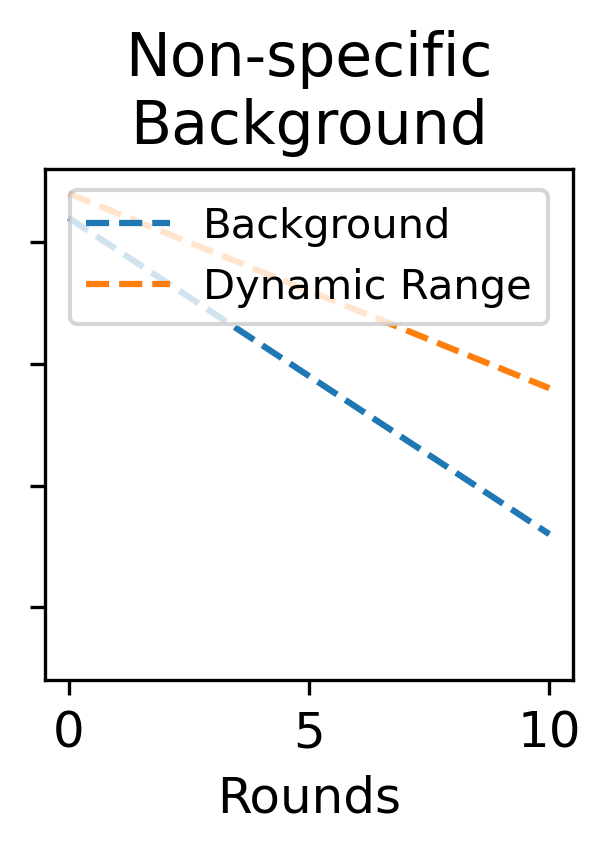

In [155]:
fig,ax = plt.subplots(figsize=(2.2,3),dpi=300)
df = pd.DataFrame(index=range(11),data=np.arange(1.1,-1,step = -.13)[0:11],columns=['Background'])
df['Dynamic Range'] = np.arange(1.2,0,step = -.08)[0:11]
df.plot(ax=ax,linestyle='--')
ax.set_yticklabels([])
ax.set_xlabel('Rounds')
ax.set_ylim(-.8,1.3)
ax.legend(loc='upper center',fontsize=10)
ax.set_title('Non-specific\nBackground')
plt.tight_layout()

In [ ]:
#
fig,ax = plt.subplots(figsize=(2.2,3),dpi=300)
df = pd.DataFrame(index=range(11),data=np.arange(1,.45,-.05,))
df.loc[0] = 2
df.loc[1] = 1.3
df.iloc[5:11,0] = np.arange(.75,1.01,.05)
df.plot(ax=ax,linestyle='--')
ax.set_yticklabels([])
ax.set_xlabel('Rounds')
ax.legend().remove()
ax.set_title('Autofluorescence')
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(figsize=(2,3),dpi=300)
df = pd.DataFrame(index=range(1,7),data=np.zeros(6))
df.plot(ax=ax,linestyle='--',color='white')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('Good        Bad')
ax.set_xlabel('Adj. Channel')
ax.legend().remove()
ax.axhline(0,color='black')
ax.set_title('Channel\nCrosstalk')
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(figsize=(2,3),dpi=300)
df = pd.DataFrame(index=range(1,7),data=np.zeros(6))
df.plot(ax=ax,linestyle='--',color='white')
ax.set_ylabel('Good        Bad')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('Adj. Round')
ax.legend().remove()
ax.axhline(0,color='black')
ax.set_title('Incomplete\nQuench')
plt.tight_layout()

## Blocking Experiment

why do later rounds have lower non-specific BG staining?

In [ ]:
import os
import skimage
import numpy as np
import tifffile
import util
import importlib
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF/')
#from mplex_image import ometiff
rootdir = '/home/groups/graylab_share/Chin_Lab/ChinData/Cyclic_Workflow/cmIF_2021-07-07_HER2A'#os.getcwd()
os.chdir(codedir)
tiffdir = f'{rootdir}/RawImages'
qcdir = f'{rootdir}/QC'
regdir = f'{rootdir}/RegisteredImages'
subdir = f'{rootdir}/SubtractedRegisteredImages'
segdir = f'{rootdir}/Segmentation'
cropdir = f'{rootdir}/Cropped'

In [ ]:
import importlib
importlib.reload(util)

In [ ]:
''' get crop coords
df = pd.DataFrame(index=os.listdir())
df = df[(df.index.str.contains('ome.tif')) & (df.index.str.contains('scene004'))]
ls_drop = ['HER2A-64_scene004_x2000y2000_c5.ome.tif','HER2A-65_scene004_x2000y2000_c5.ome.tif',
          'HER2A-63_scene004_x2000y2000_c5.ome.tif','HER2A-62_scene004_x2000y2000_c5.ome.tif']
df.drop(ls_drop,inplace=True)
dict(zip([item.split('_')[0] + "_" + 'scene004' for item in df.index],[item.split('_')[2].replace('x','').replace('y',',') for item in df.index]))
'''

# images not shared yet (11/23/2021)
'''
d_crop = {'HER2A-63_scene004': (2351,1648),
 'HER2A-64_scene004': (2604,1066),
 'HER2A-65_scene004': (2837,717),
 'HER2A-62_scene004': (2410,683)}
tu_array=(1,1)
tu_fig=(6,4.2)
for s_scene, tu_crop_corner in d_crop.items():
    os.chdir(f'{regdir}/{s_scene}')
    df_img = util.parse_org(s_end = "ORG.tif",s_start='R',type='reg')
    df_img[' '] = df_img.rounds
    df_img_color = df_img[df_img.color=='c5']
    #make arrays
    for s_index in df_img_color.index: 
        s_marker = df_img.loc[s_index,'marker']
        s_scene = df_img.loc[s_index,'scene']
        s_round = df_img.loc[s_index,'rounds']
        if s_marker == 'DAPI':
            continue
        df_dapi = df_img[(df_img.scene==s_scene) & (df_img.rounds=='R2') & (df_img.color == 'c1')]
        df_et = df_img[df_img.index==s_index]
        tu_crop = (tu_crop_corner[0] + 1250, tu_crop_corner[1] + 550, 800, 600) #
        #visualize IF roi
        tu_rescale = (800,3000)#(0,0)
        fig, ax = util.array_roi_if(df_et,df_dapi,s_label=' ',s_title=s_marker,tu_crop=tu_crop,
                tu_array=tu_array,tu_fig=tu_fig,tu_rescale=tu_rescale,i_expnorm=0)
        fig.savefig(f'{rootdir}/QC/{s_round}_{s_scene}_{s_marker}_pixelunits.png')
        #break
    #break
'''

In [ ]:
os.chdir(codedir)

In [ ]:
ls_sample = ['HER2A-62','HER2A-63','HER2A-64','HER2A-65']
df_data = pd.DataFrame()
for s_sample in ls_sample:
    
    for s_dir in os.listdir('./Data'):
        if s_dir.find(f'result_{s_sample}') > -1:
            print(s_dir)
            df_data.loc[s_dir,'slide'] = s_sample
            #df_data['scene'] = [item.split('_')[1] for item in df_data.index]
#
df_data['marker_max'] = [item.split('_')[2] for item in df_data.index]
df_data['maximum'] = [item.split('-')[-1] for item in df_data.marker_max]
df_data['marker'] = [df_data.loc[item, 'marker_max'].replace(f"-{df_data.loc[item,'maximum']}",'') for item in df_data.index]
df_data['region'] = [item.split('_')[-1].split('.')[0] for item in df_data.index]

In [ ]:
df_result = pd.DataFrame()
for s_index in df_data.index:
    print(s_index)
    df = pd.read_csv(f'Data/{s_index}',index_col=0)
    df['maximum'] = int(df_data.loc[s_index,'maximum'])
    df['marker'] = df_data.loc[s_index,'marker'] 
    df['region'] = df_data.loc[s_index,'region']
    df['slide'] = df_data.loc[s_index,'slide']
    df_result = df_result.append(df)
df_result['mean_intensity'] = df_result.mean_intensity*(df_result.maximum/65535)*256
df_result.reset_index(inplace=True)

In [ ]:
#df_all=pd.DataFrame()
for s_sample in ls_sample:
    df_slide = df_result[(df_result.slide==s_sample)]
    for s_marker in df_slide.marker.unique():
        fig, ax = plt.subplots(figsize=(3,2.5),dpi=150)
        df_plot = df_result[(df_result.marker==s_marker) & (df_result.slide==s_sample)]
        sns.boxplot(x='region', y='mean_intensity', data=df_plot, fliersize=0, ax=ax,order=['fg','bg'])
        #sns.stripplot(x='panel', y='mean_intensity', hue='region', data=df_result,ax=ax,palette='dark')
        #ax.legend(bbox_to_anchor=(.85,.35)) #loc=4
        ax.set_title(f'{s_sample} \n {s_marker} Foreground vs. Background')
        plt.tight_layout()
        fig.savefig(f'./Figures/cmIF_{s_sample}_{s_marker}_FGvBG.png')


In [ ]:
#calculate sbr

df_mean = df_result.groupby(['slide','marker','region']).mean()
df_bg = df_result.loc[df_result.region=='bg'].copy()
#break
for s_index in df_bg.index:
    df_bg.loc[s_index,'fg'] = df_mean.loc[(df_bg.loc[s_index,'slide'],df_bg.loc[s_index,'marker'],'fg'),'mean_intensity']
    df_bg['SBR'] = df_bg.fg/df_bg.mean_intensity

#fix
ls_index = df_bg[df_bg.marker=='CD45b'].index
df_bg.loc[ls_index,'marker'] = 'CD45'
df_bg.loc[ls_index,'slide'] = 'HER2A-63r'

#fix
ls_index = df_bg[df_bg.marker=='Rbt-IgG-750'].index
df_bg.loc[ls_index,'marker'] = 'CD45'
df_bg.loc[ls_index,'slide'] = 'HER2A-64p'

In [ ]:
d_names = {'HER2A-63':'CD45 first',
           'HER2A-62':'10x quench', 
           'HER2A-65':'after IgG',
           'HER2A-64':'after IgG-750',
           'HER2A-63r':'CD45 repeat', 
           'HER2A-64p':'IgG-750', 
           }

In [ ]:
#plot df_bg
ls_order = [key for key, item in d_names.items()]
ls_label = [item for key, item in d_names.items()]
from scipy import stats
for s_marker in ['CD45']: #,'CD45b'
    fig, ax = plt.subplots(figsize=(5.5,3.3),dpi=150)
    sns.boxplot(x='slide', y='SBR', data=df_bg[df_bg.marker==s_marker], fliersize=0, ax=ax, order = ls_order)
    sns.stripplot(x='slide', y='SBR', data=df_bg[df_bg.marker==s_marker], palette='dark', ax=ax, order = ls_order)
    if s_marker=='CD45':
        x = df_bg[(df_bg.marker==s_marker) & (df_bg.slide==df_bg[df_bg.marker==s_marker].groupby('slide').mean().index[0])].SBR
        y = df_bg[(df_bg.marker==s_marker) & (df_bg.slide==df_bg[df_bg.marker==s_marker].groupby('slide').mean().index[1])].SBR
        z = df_bg[(df_bg.marker==s_marker) & (df_bg.slide==df_bg[df_bg.marker==s_marker].groupby('slide').mean().index[2])].SBR
        a = df_bg[(df_bg.marker==s_marker) & (df_bg.slide==df_bg[df_bg.marker==s_marker].groupby('slide').mean().index[3])].SBR
        b = df_bg[(df_bg.marker==s_marker) & (df_bg.slide==df_bg[df_bg.marker==s_marker].groupby('slide').mean().index[3])].SBR
        c = df_bg[(df_bg.marker==s_marker) & (df_bg.slide==df_bg[df_bg.marker==s_marker].groupby('slide').mean().index[4])].SBR
        statistic, pvalue = stats.ttest_ind(x,y)
        fstatistic, fpvalue = stats.f_oneway(x,y,z,a,b,c)
        print(fpvalue)
        ax.set_title(f'{s_marker} \n p = {fpvalue:.2}')
    else:
        ax.set_title(f'{s_marker}')
    ax.set_xticklabels(ls_label)
    ax.tick_params(axis='x', labelrotation=45) 
    plt.tight_layout()
    fig.savefig(f'./Figures/cmIF_Blocking_{s_marker}_SBR.png')